### Review PER over time and create predictions for the next three seasons

#### Lets start by loading the R packages we will need

In [28]:
suppressWarnings(suppressMessages(library(rvest)))
suppressWarnings(suppressMessages(library(RSelenium)))
suppressWarnings(suppressMessages(library(data.table)))
suppressWarnings(suppressMessages(library(ggplot2)))
suppressWarnings(suppressMessages(library(plotly)))
library(IRkernel)

options(repr.plot.width = 8)
options(repr.plot.height = 4)

#### You will need the URL for the player you are looking to analyze - let's start with the GOAT :) 

In [30]:
# grab data
lebron <- "https://www.basketball-reference.com/players/j/jamesle01.html"
rD <- rsDriver()
suppressWarnings(remDr <- rD[["client"]])
suppressWarnings(remDr$navigate(lebron))
lebron_webpage <- read_html(remDr$getPageSource()[[1]])
lebron_table <- html_table(lebron_webpage, fill = TRUE)

# load all tables
for (i in 1:length(lebron_table)) 
  assign(paste0("table_",i),data.frame(lebron_table[i]))

checking Selenium Server versions:
BEGIN: PREDOWNLOAD
BEGIN: DOWNLOAD
BEGIN: POSTDOWNLOAD
checking chromedriver versions:
BEGIN: PREDOWNLOAD
BEGIN: DOWNLOAD
BEGIN: POSTDOWNLOAD
checking geckodriver versions:
BEGIN: PREDOWNLOAD
BEGIN: DOWNLOAD
BEGIN: POSTDOWNLOAD
checking phantomjs versions:
BEGIN: PREDOWNLOAD
BEGIN: DOWNLOAD
BEGIN: POSTDOWNLOAD


[1] "Connecting to remote server"
$applicationCacheEnabled
[1] FALSE

$rotatable
[1] FALSE

$mobileEmulationEnabled
[1] FALSE

$networkConnectionEnabled
[1] FALSE

$chrome
$chrome$chromedriverVersion
[1] "2.36.540469 (1881fd7f8641508feb5166b7cae561d87723cfa8)"

$chrome$userDataDir
[1] "/var/folders/j_/kj9hgmhs2hl7x25656385fk40000gn/T/.org.chromium.Chromium.UIHZTJ"


$takesHeapSnapshot
[1] TRUE

$pageLoadStrategy
[1] "normal"

$databaseEnabled
[1] FALSE

$handlesAlerts
[1] TRUE

$hasTouchScreen
[1] FALSE

$version
[1] "64.0.3282.186"

$platform
[1] "Mac OS X"

$browserConnectionEnabled
[1] FALSE

$nativeEvents
[1] TRUE

$acceptSslCerts
[1] FALSE

$acceptInsecureCerts
[1] FALSE

$locationContextEnabled
[1] TRUE

$webStorageEnabled
[1] TRUE

$browserName
[1] "chrome"

$takesScreenshot
[1] TRUE

$javascriptEnabled
[1] TRUE

$cssSelectorsEnabled
[1] TRUE

$setWindowRect
[1] TRUE

$unexpectedAlertBehaviour
[1] ""

$webdriver.remote.sessionid
[1] "b4aa599d9ce30adbdd4e2eb5f5a1c793"

$id
[1] "b


Selenium message:no such window: target window already closed
from unknown error: web view not found
  (Session info: chrome=64.0.3282.186)
  (Driver info: chromedriver=2.36.540469 (1881fd7f8641508feb5166b7cae561d87723cfa8),platform=Mac OS X 10.13.3 x86_64)



ERROR: Error: 	 Summary: NoSuchWindow
 	 Detail: A request to switch to a different window could not be satisfied because the window could not be found.
	 Further Details: run errorDetails method


#### The function we used pulled all datasets from Lebron's page. Let's clean up the tables we want to keep and remove the rest from memory. ***THESE TABLE POSITIONS MAY CHANGE

In [31]:
# keep the following datasets
season_stats <- table_27[1:15, ]
season_totals <- table_29[1:15, ]
per_100 <- table_31[1:15, ]
advanced <- table_32[1:15, ]
playoff <- table_35[1:12, ]

to_keep <- c("season_stats","season_totals", 'per_100', 'advanced', 'playoff')

rm(list=ls()[! ls() %in% to_keep])

#### Let's take a look at Lebron's PER by season

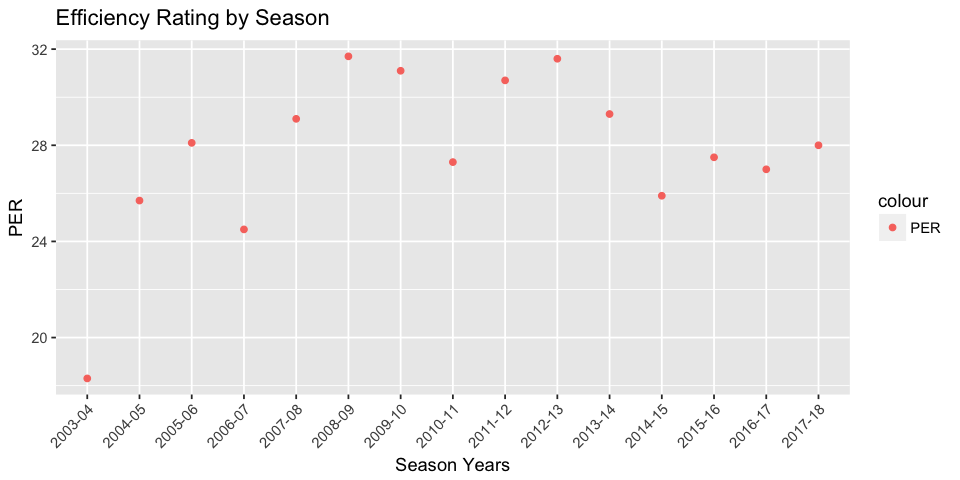

In [32]:
# graph PER
g <- ggplot(advanced, aes(Season)) + 
     geom_point(aes(y = PER, colour = "PER")) + ggtitle('Efficiency Rating by Season') + 
     xlab('Season Years') + ylab('PER')
g <- g + theme(axis.text.x = element_text(angle = 45, hjust = 1))
g

#### Let's next model and graph a couple functions which reflect Lebron's PER over his career

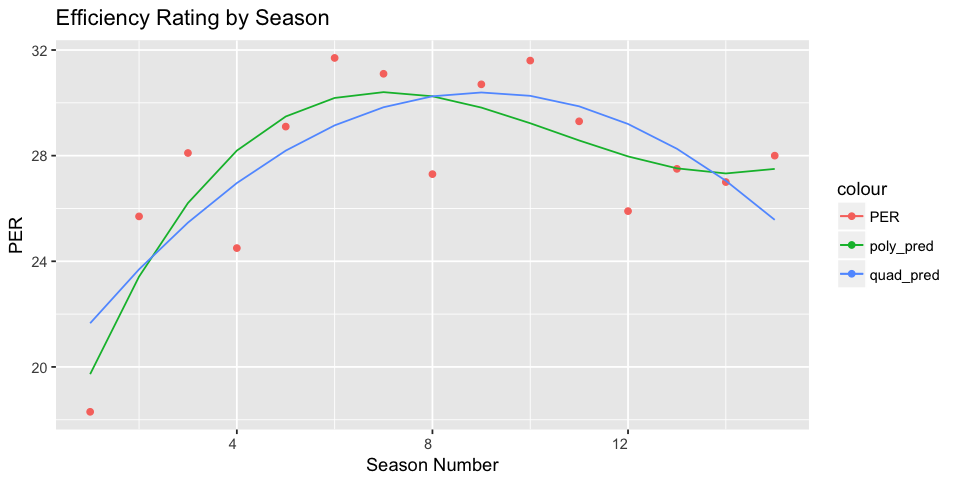

In [33]:
advanced$Seasons <- 1:nrow(advanced)

# quadratic fit
quad_fit <- lm(PER~poly(Seasons, 2, raw = TRUE), data = advanced)
quad_val <- data.frame(quad_pred = c(quad_fit$fitted.values))

# poly fit
poly_fit <- lm(PER~poly(Seasons, 3, raw = TRUE), data = advanced)
poly_val <- data.frame(poly_pred = c(poly_fit$fitted.values))

# merge predictions
vals <- cbind(quad_val, poly_val)

# merge to dataframe
advanced <- cbind(advanced, vals)

# plot PER performance over time
g <- ggplot(advanced, aes(Seasons)) + 
     geom_point(aes(y = PER, colour = 'PER')) + ggtitle('Efficiency Rating by Season') +
     geom_line(aes(y = poly_pred, colour = 'poly_pred')) +
     geom_line(aes(y = quad_pred, colour = 'quad_pred')) +
     xlab('Season Number') + ylab('PER')
g <- g + theme(axis.text.x = element_text(angle = 0, hjust = 1))
g

#### Quadratic functions are reasonable models for an athlete's career. Performance typically starts low, peaks around mid career and tails off again in the final years. We also look at a 3rd degree polynomial function which is flexible enough to account for the slight uptick in Lebron's PER over the last couple years. 

#### Finally, let's come up with some predictions for the next three seasons of Lebron's career

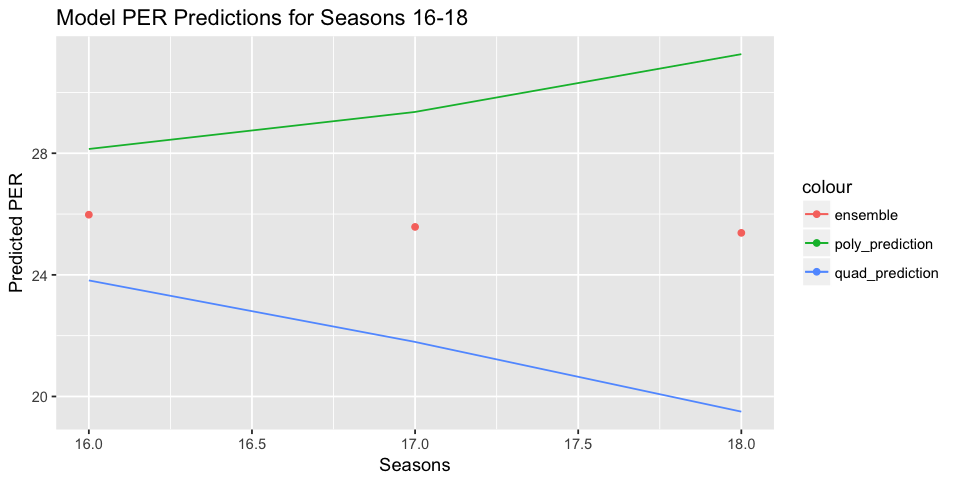

In [34]:
# projecting PER going forward
pred_season <- data.frame(Seasons = c(16:18))

# predicted performance
data_predictions <- data.frame(Seasons = c(16:18), 
                               quad_prediction = c(predict(quad_fit, newdata = pred_season)), 
                               poly_prediction = c(predict(poly_fit, newdata = pred_season))) 
data_predictions$ensemble <- (data_predictions$quad_prediction + data_predictions$poly_prediction) / 2         

# viz predictions
g <- ggplot(data_predictions, aes(Seasons)) + 
     geom_line(aes(y = quad_prediction, colour = "quad_prediction")) +
     geom_line(aes(y = poly_prediction, colour = "poly_prediction")) +
     geom_point(aes(y = ensemble, colour = "ensemble")) +
     ggtitle("Model PER Predictions for Seasons 16-18") + ylab("Predicted PER") + xlab("Seasons")
g

#### We have both a higher end predictions and a lower end prediction, and then the ensemble average of the two predictions. All in all, our most viable prediction is that Lebron will be somewhere in the 25 range in terms of PER for the next 3 seasons, with a low prediction of around 20 and a high prediction near 30!

### End